# Setup

In [63]:
import pandas as pd
import numpy as np
from itertools import combinations

from scipy.stats import mannwhitneyu, spearmanr, t, chisquare, chi2_contingency

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

sns.set_style('darkgrid')

In [64]:
colors = ['#003DA6', '#B53A6D', '#7AC4A5', '#F17F4C', '#15AFD0']

basefont = mpl.font_manager.FontProperties(family='DejaVu Sans', style='normal', size=14)
mpl.rcParams['axes.titlesize'] = 14

plot_style = {
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'grid.color': '#aaaaaa',
    'grid.linewidth': '0.8',
    'grid.linestyle': '-',
    'axes.titlesize': 14,
    'legend.framealpha': 1.0,
    'errorbar.capsize': 8
}

plt.rcParams.update(plot_style)

# Preprocessing

In [158]:
df = pd.read_csv('../../Private/all_data.csv')

# Filter out non-consents and people who indicating spending no time working on AI systems
df['Screener'] = pd.to_numeric(df.Screener, errors = 'coerce')
df = df[(df.Consent == 1) & (df.Screener > 0)]

# Drop unneeced columns
df.drop(columns=['StartDate', 'EndDate', 'Status', 'RecordedDate', 'UserLanguage', 'sig_year_5_TEXT',
                 'comp_year_5_TEXT', 'Consent', 'more_thoughts'], inplace=True)

# Ignore "I don't know" responses for cost and GPU-hours
df['CompCost'] = df.CompCost.apply(lambda x: pd.NA if x == "6" else x)
df['CompGPUs'] = df.CompGPUs.apply(lambda x: pd.NA if x == "7" else x)
df['SigCost'] = df.SigCost.apply(lambda x: pd.NA if x == "6" else x)
df['SigGPUs'] = df.SigGPUs.apply(lambda x: pd.NA if x == "7" else x)

# All columns currently have numeric data but are recorded as strings -- convert them all
for column in df.columns[5:]:
    df[column] = pd.to_numeric(df[column], errors = 'coerce')

# Set the values for "sector" to their text meanings
sector_values = {0: 'Academia', 1: 'Industry', 2: 'Government', 3: 'Other'}
df['Sector'] = df.Sector.apply(lambda x: sector_values[x] if x in sector_values else pd.NA)

# Set the values for "company size" to their text meanings
size_values = {0: '<50 Employees', 1: '50-100 Employees', 2: '101-500 Employees', 3: '>500 Employees'}
df['CompanySize'] = df.CompanySize.apply(lambda x: size_values[x] if x in sector_values else pd.NA)

# Create a new column called "PrioritySimplified" and set values for "TopPriority" to text values
priorities = {0: 'Collecting more data', 1: 'Refining or cleaning data', 2: 'Purchasing more or higher-quality compute',
             3: 'Hiring more programmers or engineers', 4: 'Hiring researchers', 5: 'Doing more evaluation or testing'}
df['TopPriority'] = df.TopPriority.map(priorities)
simplified = {'Collecting more data': 'Data', 'Refining or cleaning data': 'Data',
             'Hiring researchers': 'Talent', 'Hiring more programmers or engineers': 'Talent',
             'Purchasing more or higher-quality compute': 'Compute',
             'Doing more evaluation or testing': 'Evaluation'}
df['PrioritySimplified'] = df.TopPriority.map(simplified)

# If the most significant project was also the most compute-intensive, duplicate the answers to both columns
df['CompCost'] = df.apply(lambda x: x['CompCost'] if x['SameProject'] == 0. else x['SigCost'], axis=1)
df['CompGPUs'] = df.apply(lambda x: x['CompGPUs'] if x['SameProject'] == 0. else x['SigGPUs'], axis=1)
df['CompTeamSize'] = df.apply(lambda x: x['CompTeamSize'] if x['SameProject'] == 0. else x['SigTeamSize'], axis=1)
df['CompYear'] = df.apply(lambda x: x['CompYear'] if x['SameProject'] == 0. else x['SigYear'], axis=1)
df['CompComponent'] = df.apply(lambda x: x['CompComponent'] if x['SameProject'] == 0. else x['SigComponent'], axis=1)

# Create separate dfs for different subsets of data
all_responses = df.copy()
no_snowball = df[df.DistributionChannel == 'email'].copy()
completed = df[df.Finished == 1].copy()
df = no_snowball.copy()  # This should be the DEFAULT dataset, so I'm renaming this variable to make sure if "df" is accidentally used it's the right data

<ipython-input-158-e88e28d3f17d>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PrioritySimplified'] = df.TopPriority.map(simplified)


# Methodology

<br/><br/>

"In total, we received 410 complete responses (and 123 partially completed responses) [...] In addition, via snowball sampling conducted by Stanford’s Institute for Human-Centered AI, we collected an additional 38 completed responses and nine partial responses."

In [21]:
no_snowball.Finished.value_counts()

1    410
0    123
Name: Finished, dtype: int64

In [23]:
all_responses.Finished.value_counts() - no_snowball.Finished.value_counts()

1    38
0     9
Name: Finished, dtype: int64

# Results

<br/>
<br/>

## Respondent Demographics

"Of our 410 complete responses, 274 (67%) were academics, 120 (29%) reported working in industry, and 14 (3%) reported a government affiliation. [FN: One respondent selected their affiliation as “None of these” while one other respondent completed the survey but did not provide a sector affiliation. No respondent who did not finish the survey indicated a sector affiliation.]"

In [29]:
# Print out the value counts for non-snowball respondents
no_snowball[['Finished', 'Sector']].value_counts(dropna = False)

Finished  Sector    
1         Academia      274
0         NaN           123
1         Industry      120
          Government     14
          Other           1
          NaN             1
dtype: int64

"To analyze the intra-industry divide, we asked respondents who reported working in industry about the size of their organization; 84 reported working for a company with over 500 employees while 35 reported working for a company with 500 or fewer employees (see Figure 1). [FN: [...] One respondent indicated working in industry but did not provide information about their organization’s size.]"

In [31]:
# Show value counts (Gov was asked about org size as well but we do not discuss this in the report)
no_snowball[['Sector', 'CompanySize']].value_counts(dropna = False)

Sector      CompanySize      
Academia    NaN                  274
NaN         NaN                  124
Industry    >500 Employees        84
            <50 Employees         17
Government  >500 Employees        10
Industry    101-500 Employees      9
            50-100 Employees       9
Government  101-500 Employees      3
            <50 Employees          1
Industry    NaN                    1
Other       >500 Employees         1
dtype: int64

Left hand plot values:
Academia                 274
Industry                 120
Government               14
Other                    1
——————————
Right hand plot values:
<50 Employees            17
50-100 Employees         9
101-500 Employees        9
>500 Employees           84


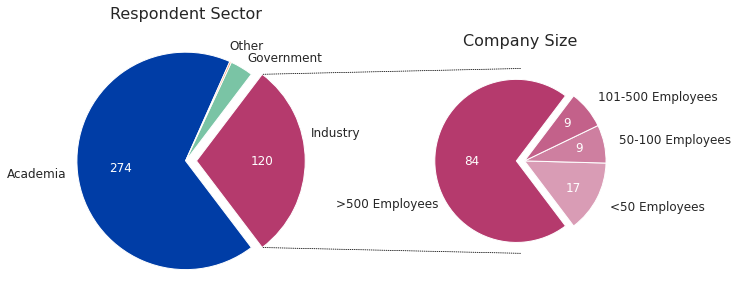

In [24]:
def figure1(df, output_folder, show = False):

    # Create a plot that will contain two pie charts within it
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
    fig.subplots_adjust(wspace=0)

    # Extract the relevant counts from the data
    counts = df.Sector.value_counts().tolist()
    labels = df.Sector.value_counts().index.tolist() 

    # Print the data that will be plotted
    if show: 
        print('Left hand plot values:')
        for lab, val in zip(labels, counts):
            print(f'{lab:<25s}{val}')
        print('——————————')

    # This caluclation finds the right starting angle to plot with, so that the middle of the industry slice lies on the horizontal axis
    angle = 360 * ((sum(counts[1:]) - 0.5 * counts[1]) / sum(counts))

    # Plot the left-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
    wedges, text, autotexts = ax0.pie(counts, labels = labels, colors = colors, startangle = angle, autopct='',  # For now, don't add numbers on the slices
                                      explode = [0, 0.1, 0, 0],  # The "industry" slice will be slightly pulled out of the center
                                      textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12})

    # Manually adjust the locations of some of the labels so that they don't overlap
    text[1].set_y(0.25)
    text[1].set_x(1.15)
    text[3].set_y(1.05)
    text[3].set_x(0.4)

    # For academia and industry ONLY, add white numbers to the pie slices (the slices for government and other are too small)
    for a, c in zip(autotexts[:2], counts[:2]):
        a.set_text(f'{c}')
        a.set_color('white')


    # The right-hand side of the pie chart should consist of 4 different shades of the same red used to plot "industry" as a whole
    inset_colors = [to_rgba(colors[1], alpha = a) for a in reversed([1., 0.8, 0.65, 0.5])]

    # Extract the relevant counts and labels from the data
    labels = ['<50 Employees', '50-100 Employees', '101-500 Employees', '>500 Employees']
    counts = [len(df[(df.Sector == 'Industry') & (df.CompanySize == lab)]) for lab in labels]

    # Print the data that will be plotted
    if show:
        print('Right hand plot values:')
        for lab, val in zip(labels, counts):
            print(f'{lab:<25s}{val}')

    # This calculation finds the right starting angle to plot with, such that the largest slice (>500 Employees) ends up facing left and horizontally aligned with the left-hand "industry" slice
    angle = -360 * 0.5 * sum(counts[:-1]) / sum(counts)

    # Plot the right-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
    # This one is more difficult because we want three slices (the "small" company slices) to be exploded as a *single* slice, not to be exploded separately
    # To do this, we will first make a (white, non-visible) plot with each one exploded separately, but then manipulate the geometry of the slices and color them in
    wedges, text, autotexts = ax1.pie(counts, labels = labels, startangle = angle, colors = ['white'] * 4,  # Colors are initially white because we will readjust the geometry of these slices later
                                      explode = [.1,.1,.1,0],  # Ensure that all three of the "small" company items are exploded (these will be reformatted into a single exploded slice, below)
                                      textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12}, autopct='',  # As before, leave numbers blank for now
                                      radius = 0.75)  # Make this pie chart smaller than the left-hand one

    # Manually adjust the locations of the ">500 Employees" label so that it doesn't overlap with a label from the left-hand graph
    text[3].set_y(-0.4)
    text[3].set_x(-0.75)

    # The white patches will be overwritten with slightly adjusted red patches, so move them to the back of the image 
    [w.set_zorder(-1) for w in wedges]


    # The following code groups the three small company slices together and manipulates the geometry of both groups
    groups = [[0,1,2], [3]]
    radfraction = 0.05
    patches = []
    for i in groups:
        ang = np.deg2rad((wedges[i[-1]].theta2 + wedges[i[0]].theta1)/2,)
        for j in i:
            we = wedges[j]
            center = (radfraction*we.r*np.cos(ang), radfraction*we.r*np.sin(ang))
            patches.append(mpatches.Wedge(center, we.r, we.theta1, we.theta2))

    # Create a patch collection object out of the geometrically adjusted slices, color them in, and add them to the right-hand plot
    collection = PatchCollection(patches, cmap = LinearSegmentedColormap.from_list('custom_map', inset_colors, N=4))
    collection.set_array(np.array([0,1,2,3]))
    ax1.add_collection(collection)

    # Add numerical labels to the slices in the right-hand plot in white font 
    for a, c in zip(autotexts, counts):
        a.set_text(f'{c}')
        a.set_color('white')


    # Drawing connecting lines
    theta1, theta2 = ax0.patches[1].theta1, ax0.patches[1].theta2
    center, r = ax0.patches[1].center, ax0.patches[1].r
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(0, .85), xyB=(x, y),
                          coordsA="data", coordsB="data", axesA=ax1, axesB=ax0)
    con.set_color([0, 0, 0])
    con.set_linewidth(0.8)
    con.set_linestyle(':')
    ax1.add_artist(con)

    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(0, -0.85), xyB=(x, y), coordsA="data",
                          coordsB="data", axesA=ax1, axesB=ax0)
    con.set_color([0, 0, 0])
    con.set_linewidth(0.8)
    con.set_linestyle(':')
    ax1.add_artist(con)

    # Do some final visualization touch-up and save the figure 
    ax0.set_title('Respondent Sector', fontsize=16, fontname='DejaVu Sans')
    ax1.set_title('Company Size', fontsize=16, fontname='DejaVu Sans', y=.9)
    fig.savefig(f'../results/{output_folder}/Fig1.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure1(no_snowball, 'figures', show = True)
figure1(all_responses, 'supplemental/with_snowball')
figure1(completed, 'supplemental/no_partial_responses')

              CV   NLP    RL  Robotics  Other
Academia    95.0  83.0  59.0      58.0  107.0
Industry    49.0  58.0  17.0      13.0   47.0
Government   6.0   2.0   4.0       1.0    6.0


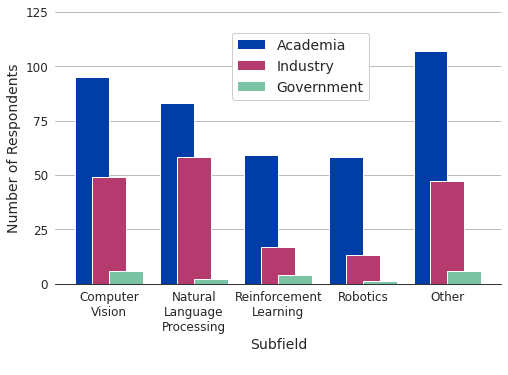

In [33]:
def figure2(df, output_folder, show = False):

    # Create a 3x5 matrix to hold the number of academics, industry researchers, and government researchers in each subfield, then loop over each possible combination
    # NOTE: this excludes the one person who responded to the subfield question but did not identify as either an academic, industry researchers, or governemnt researcher
    data = np.zeros((3, 5))
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        for j, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other']):
            data[i,j] = df[df.Sector == s][f].sum()

    # Print the data being plotted
    data_df = pd.DataFrame({f: data[:, i] for i, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other'])}, index = ['Academia', 'Industry', 'Government'])
    if show: print(data_df)

    # Initialize labels for plotting and create figure
    labels = ['Computer\nVision', 'Natural\nLanguage\nProcessing', 'Reinforcement\nLearning', 'Robotics', 'Other']
    fig, ax = plt.subplots(figsize=(8,5))

    # Add another layer to each of the five columns for all academics, then all industry researchers, then all government researchers and update the starting position for the next iteration
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        ax.bar(np.arange(5) - 0.2 + 0.2 * i, data[i], color=colors[i], label = s, width = 0.4)

    # Adjust figure aesthetics and labels
    ax.set_ylabel('Number of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_yticklabels([str(i) for i in np.arange(0, 150, 25)], fontsize=12, fontname='DejaVu Sans')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels, fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('Subfield\n', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc='center', bbox_to_anchor = (0.55, 0.8))

    # Save and display the image
    plt.savefig(f'../results/{output_folder}/Fig2.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure2(no_snowball, 'figures', show = True)
figure2(all_responses, 'supplemental/with_snowball')
figure2(completed, 'supplemental/no_partial_responses')

"Academics were slightly overrepresented in robotics and reinforcement learning, while industry was significantly overrepresented in natural language processing. [FN: The overrepresentation of industry researchers was significant using a Chi-squared test of independence at p = 0.004 after applying Bonferroni correction for repeated significance testing. Other differences between industry and academic makeup were not significant.]"

In [61]:
def test_field_diff(col_name):
    # Look only at the data from either academics or industry researchers
    subset = no_snowball[(no_snowball.Sector == 'Academia') | (no_snowball.Sector == 'Industry')]
    
    # Extract all the relevant values for the frequency table
    acad_no = sum((subset.Sector == 'Academia') & (subset[col_name] == 0))
    ind_no = sum((subset.Sector == 'Industry') & (subset[col_name] == 0))
    acad_yes = sum((subset.Sector == 'Academia') & (subset[col_name] == 1))
    ind_yes = sum((subset.Sector == 'Industry') & (subset[col_name] == 1))
    
    # Which sector is overrepresented? Then return the p-value (multiplied by 5 for Bonferroni correction)
    overrepresented_sector = 'Academia' if acad_yes / (acad_yes + acad_no) >= ind_yes / (ind_yes + ind_no) else 'Industry'
    return overrepresented_sector, min(1., chi2_contingency([[acad_yes, acad_no], [ind_yes, ind_no]])[1] * 5)
    

# Iterate over each major field with this test
for field in ['CV', 'Robotics', 'NLP', 'RL', 'Other']:
    print(f"{field}: {test_field_diff(field)[0]} is overrepresented with p = {test_field_diff(field)[1]}")

CV: Industry is overrepresented with p = 1.0
Robotics: Academia is overrepresented with p = 0.10337647841534339
NLP: Industry is overrepresented with p = 0.004438661393664655
RL: Academia is overrepresented with p = 0.5858987520922116
Other: Industry is overrepresented with p = 1.0


"Although a few categories under the “Other” heading received as many responses as the top-level robotics category, [FN: In particular, 74 respondents reported working on “algorithmic or architecture analysis,” as compared to 72 respondents indicating working in the top-level category of robotics.]"

In [59]:
# Robotics was the smallest top-level field with 72 responses
for col in no_snowball.columns[71:-1]:
    if no_snowball[col].sum() >= 72:
        print(f"{col}: {no_snowball[col].sum()}")

CV: 150.0
Robotics: 72.0
NLP: 143.0
RL: 81.0
Other: 160.0
ImageRecognition: 83.0
AlgorithmicOrArchitectureAnalysis: 74.0


## Compute Is Not the Primary Constraint for a Majority of AI Projects

<br/>
<br/> 

### Finding 1.1. Researchers report talent as the primary factor contributing to the success of their most significant past projects. 

"Our instrument asked respondents to think about two specific projects they had worked on within the previous five years: the project that they felt had contributed the most to progress in their AI field (hereafter “most significant project”), and their most compute-intensive project. Interestingly, 67% of respondents reported that these two projects were the same project."

In [80]:
# Show the breakdown by sector for percent indiating "same project" 
no_snowball.SameProject.value_counts(normalize = True)

1.0    0.674757
0.0    0.325243
Name: SameProject, dtype: float64

In [81]:
# Also show the percent answering "yes" based on industry vs. academia
print('Academia:', no_snowball[no_snowball.Sector == 'Academia'].SameProject.value_counts(normalize = True)[1])
print('Industry:', no_snowball[no_snowball.Sector == 'Industry'].SameProject.value_counts(normalize = True)[1])

Academia: 0.6893939393939394
Industry: 0.6634615384615384


"However, when asked how important several factors were in the success of the researcher’s “most significant” project, only 52% of respondents rated “large amounts of compute” as very or extremely important. By contrast, 90% of respondents rated “specialized knowledge, talent, or skills” as very or extremely important for the same project’s success, as shown in Figure 3."

                                            Proportion        CI
Unique Data                                   0.514493  0.048285
Size of Team                                  0.168675  0.036133
Specialized\nKnowledge, Talent,\nor Skills    0.896386  0.029407
Large Amounts\nof Compute                     0.516908  0.048277


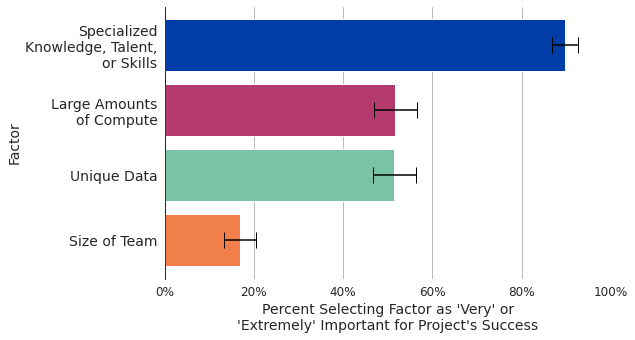

In [13]:
def figure3(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize = (8,5))

    # Extract the proportion of respondents rating each factor as very or extremely important
    props, counts = np.zeros((4,)), np.zeros((4,))
    for i, col in enumerate(['Data', 'TeamSize', 'Talent', 'Compute']):
        counts[i] = len(df[~df[f'Success{col}'].isna()])
        props[i] = len(df[df[f'Success{col}'] >= 3]) / counts[i]

    # Use the equation 1.96 * sqrt( p * (1-p) / n ) to calculate the standard error for the sample, then calculate the confidence intervals
    cis = t.ppf(1 - 0.05/2, df = counts - 1) * np.sqrt(props * (1 - props) / counts)

    # Print the final data being plotted
    labels = ['Unique Data', 'Size of Team', 'Specialized\nKnowledge, Talent,\nor Skills', 'Large Amounts\nof Compute']
    data_df = pd.DataFrame({'Proportion': props, 'CI': cis}, index = labels)
    if show: print(data_df)

    # Plot the results on a bar chart and add error bars corresponding to the margins of error
    for x, i in enumerate(np.argsort(props)[::-1]):
        ax.barh(4 - x, props[i], color = colors[x], label = labels[i])
        ax.errorbar(props[i], 4 - x, xerr = cis[i], color='black', fmt='none')

    # Adjsut the aesthetics of the plot and save it
    ax.set_yticks([1,2,3,4])
    ax.set_yticklabels(np.array(labels)[np.argsort(props)], fontname='DejaVu Sans', fontsize=14)
    ax.set_ylabel('Factor', fontsize=14, fontname='DejaVu Sans')
    ax.set_xlabel('Percent Selecting Factor as \'Very\' or\n\'Extremely\' Important for Project\'s Success', 
                  fontsize=14, fontname='DejaVu Sans')
    ax.grid(False)
    ax.grid(axis='x')
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=12, fontname='DejaVu Sans')
    plt.savefig(f'../results/{output_folder}/Fig3.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure3(no_snowball, 'figures', show = True)
figure3(all_responses, 'supplemental/with_snowball')
figure3(completed, 'supplemental/no_partial_responses')

### Finding 1.2. Most researchers would not prioritize compute if they had more funding.

"52% of respondents reported that they would spend the excess money on either “hiring researchers” or “hiring more programmers or engineers,” which are binned together in Figure 4 under the heading “Talent.”"

            Proportion        CI
Talent        0.517401  0.047309
Data          0.215777  0.038945
Compute       0.204176  0.038163
Evaluation    0.062645  0.022942


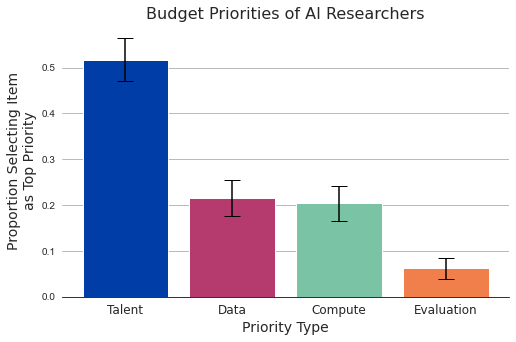

In [45]:
def figure4(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize = (8,5))

    # Extract the proportion of respondents selecting each of the four binned options and calculate the confidence intervals for each
    props = np.array(df.PrioritySimplified.value_counts(normalize=True))
    n = df.PrioritySimplified.value_counts(dropna = True).sum()
    cis = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt(props * (1 - props) / df.PrioritySimplified.value_counts().sum())

    # Print the final data being plotted
    data_df = pd.DataFrame({'Proportion': props, 'CI': cis}, index = df.PrioritySimplified.value_counts().index)
    if show: print(data_df)

    # Plot the results on a bar chart and add error bars corresponding to the margins of error
    for i in range(4):
        ax.bar(i, props[i], width=0.8, color=colors[i])
    ax.errorbar(np.arange(4), props, yerr=cis, color='black', fmt='none')

    # Adjsut the aesthetics of the plot and save it
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(df.PrioritySimplified.value_counts().index, fontsize=12, fontname='DejaVu Sans')
    ax.set_title('Budget Priorities of AI Researchers', fontsize=16, fontname='DejaVu Sans')
    ax.set_xlabel('Priority Type', fontsize=14, fontname='DejaVu Sans')
    ax.set_ylabel('Proportion Selecting Item\nas Top Priority', fontsize=14, fontname='DejaVu Sans')
    plt.savefig(f'../results/{output_folder}/Fig4.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure4(no_snowball, 'figures', show = True)
figure4(all_responses, 'supplemental/with_snowball')
figure4(completed, 'supplemental/no_partial_responses')

### Finding 1.3. When researchers are forced to revise their research plans, it is due to talent or data limitations more often than compute limitations.

            Reject  Revise  Abandon
Compute      1.993   2.579    1.593
Data         2.518   2.867    2.019
Researcher   2.538   2.676    2.126


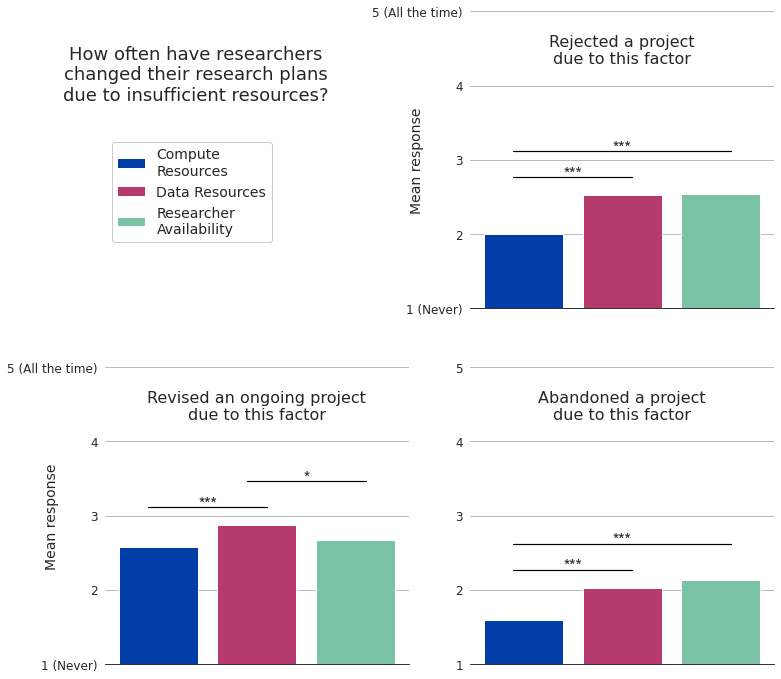

In [66]:
def figure5(df, output_folder, show = False):
    # Create a two-by-two grid of subplots (the top left grid will only contain a legend)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))

    # Create a dataframe to save mean values to as they are calculated
    data_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])

    # Iterate over each of the three axes object, each of which refers to a different hypothetical situation
    for i, (ax, situation) in enumerate(zip([axes[0][1], axes[1][0], axes[1][1]], ['Reject', 'Revise', 'Abandon'])):
        cols = [f'Compute{situation}', f'Data{situation}', f'Researcher{situation}']
        labs = ['Compute\nResources', 'Data Resources', 'Researcher\nAvailability']

        # For each factor, plot a single bar on the relevant axis showing the mean values (plus 1, since our data is stored in the range [0,4] but we want to plot in the range [1,5])
        for j, (col, lab) in enumerate(zip(cols, labs)):
            ax.bar(j, df[col].mean() + 1., color=colors[j], label=lab)

            # Also update the dataframe of final results
            data_df.loc[lab.split()[0], situation] = round(df[col].mean() + 1., 3)

        # Set the appropriate y-scale and remove xticks
        ax.set_ylim([1.,5.])
        ax.set_yticks(np.arange(1,6))
        ax.set_yticklabels([str(n) for n in np.arange(1, 6)], fontsize=12, fontname='DejaVu Sans')
        ax.set_xticks([])


        # Next, calculate each of the three two-way comparisons for this subplot to assess significant differences in arrays
        # Create an iterator variable that tracks how many horizontal bars have already been stacked on top of each other
        height = 0

        # Iterate over each relevant pair of columns 
        for (ind1, col1), (ind2, col2) in combinations(enumerate(cols), 2):

            # Calculate the p-value of a Mann-Whitney U test
            p = mannwhitneyu(df[col1].dropna(), df[col2].dropna())[1]

            # If the p-value is significant (using a Bonferroni correction with three tests per question), and no horizontal bars have been plotted yet, 
            # then plot a horizontal bar just over the taller of the two columns in this comparison 
            if p < 0.05 / 3:
                if height == 0:
                    height = max(df[col1].mean() + 1., df[col2].mean() + 1.) + 0.25

                # If a horizontal bar has already been plotted, then just plot the next one slightly above the last-plotted one
                else: height += 0.35
                ax.plot([ind1 - 0.1, ind2 + 0.1], [height] * 2, color='black', linewidth=1.2)

                # Choose the right annotation out of three options based on the p-value (again using a Bonferroni correction given three tests per question), 
                # and add an annotation to the plot, halfway along the horizontal bar
                annotation = '*' if p > 0.01 / 3 else '**'
                if p < 0.001 / 3: annotation = '***'
                ax.annotate(annotation, xy=[(ind1 + ind2) / 2, height + 0.05], ha='center', va='center', fontsize=16)


    # For the top-right and bottom-left axes, adjust the labels of the y-ticks to show the range of responses
    for ax in ([axes[0][1], axes[1][0]]):
        ax.set_yticklabels(['1 (Never)', '2', '3', '4', '5 (All the time)'], fontsize=12, fontname='DejaVu Sans')
        ax.set_ylabel('Mean response', fontsize=14, fontname='DejaVu Sans')
        ax.yaxis.set_label_coords(-.15, .5)

    # Add annotations to each plot showing which hypothetical situation it represents
    for ax, lab in zip([axes[0][1], axes[1][0], axes[1][1]], 
                       ['Rejected a project', 'Revised an ongoing project', 'Abandoned a project']):
        ax.annotate(f'{lab}\ndue to this factor', xy=(1., 4.3), ha='center', fontsize=16, fontname='DejaVu Sans')


    # Adjust the top-left subplot so that it contains a legend and a question describing the results
    handles, labels = axes[0][1].get_legend_handles_labels()
    axes[0][0].legend(handles, labels, prop=basefont, loc=3, bbox_to_anchor=(0., 0.2))
    axes[0][0].grid(False)
    axes[0][0].axis(False)
    axes[0][0].annotate('How often have researchers\nchanged their research plans\ndue to insufficient resources?',
                       xy=(0.3, 0.7), xycoords='axes fraction', ha='center', fontsize=18, fontname='DejaVu Sans')

    # Print the full array of means
    if show: print(data_df)

    # Save the final result
    plt.savefig(f'../results/{output_folder}/Fig5.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure5(no_snowball, 'figures', show = True)
figure5(all_responses, 'supplemental/with_snowball')
figure5(completed, 'supplemental/no_partial_responses')

"198 respondents (44%) responded “never” to this question. Strategy documents frequently suggest that this is a problem that more heavily impacts academics than industry. While academic researchers are somewhat more likely to report rejecting projects due to a lack of compute, the modal response for academics is still to say that they “never” reject projects due to insufficient compute, with 125 researchers (40%) responding this way."

In [75]:
# Print out the overall frequency of answers
print(no_snowball.ComputeReject.value_counts())

# And also print out the percentages 
print(no_snowball.ComputeReject.value_counts(normalize = True))

0.0    179
1.0    105
2.0     90
3.0     31
4.0      8
Name: ComputeReject, dtype: int64
0.0    0.433414
1.0    0.254237
2.0    0.217918
3.0    0.075061
4.0    0.019370
Name: ComputeReject, dtype: float64


In [77]:
# Check whether the responses from academics and industry are significantly different
mannwhitneyu(no_snowball[no_snowball.Sector == 'Academia'].ComputeReject, no_snowball[no_snowball.Sector == 'Industry'].ComputeReject)

# Print the mean response for academia and industry, separately
print('Mean for academia:', no_snowball[no_snowball.Sector == 'Academia'].ComputeReject.mean())
print('Mean for industry:', no_snowball[no_snowball.Sector == 'Industry'].ComputeReject.mean())

Mean for academia: 1.0879120879120878
Mean for industry: 0.8403361344537815


In [79]:
# Print out the overall frequency of answers (for academia)
print(no_snowball[no_snowball.Sector == 'Academia'].ComputeReject.value_counts())

# And also print out the percentages (for academia)
print(no_snowball[no_snowball.Sector == 'Academia'].ComputeReject.value_counts(normalize = True))

0.0    108
1.0     70
2.0     64
3.0     25
4.0      6
Name: ComputeReject, dtype: int64
0.0    0.395604
1.0    0.256410
2.0    0.234432
3.0    0.091575
4.0    0.021978
Name: ComputeReject, dtype: float64


### Finding 1.4. Compute is regarded as the most significant factor contributing to the last decade of AI progress, but over the next decade researchers anticipate that it will be surpassed by algorithmic improvements.  

"When asked whether they agreed or disagreed with the statement “Progress in AI over the past decade was the result of [factor],” overwhelming majorities responded that they somewhat or strongly agreed that each factor contributed to AI progress. In addition, 242 respondents (59%) indicated strong agreement with the claim that past AI progress has been driven by compute—the most of any category."

In [87]:
# Create arrays to hold the number agreeing or strongly agreeing for each factor, and total responses
agreement = []
strong_agreement = []
total = []

# Loop over each factor and caluclate the relevant values
for factor in ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support']:
    total.append(len(no_snowball[~no_snowball[f'Past{factor}'].isna()]))
    agreement.append(len(no_snowball[no_snowball[f'Past{factor}'] >= 3.]))
    strong_agreement.append(len(no_snowball[no_snowball[f'Past{factor}'] >= 4.]))
    
# Format the results into a dataframe and print it out
agreement_rates = pd.DataFrame({'Factor': ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support'],
                               'Agreeing': agreement, 'Strongly Agreeing': strong_agreement, 'Total Responses': total, 
                               'Percent Agreeing': 100 * np.array(agreement) / np.array(total), 
                               'Percent Strongly Agreeing': 100 * np.array(strong_agreement) / np.array(total)})
print(agreement_rates)

        Factor  Agreeing  Strongly Agreeing  Total Responses  \
0      Compute       379                242              412   
1         Data       351                195              411   
2   Algorithms       319                126              410   
3  Researchers       316                131              410   
4      Support       322                136              411   

   Percent Agreeing  Percent Strongly Agreeing  
0         91.990291                  58.737864  
1         85.401460                  47.445255  
2         77.804878                  30.731707  
3         77.073171                  31.951220  
4         78.345499                  33.090024  


"In particular, the percent who “strongly agree” that more compute would be a driver of future AI progress fell from 59% to 40%, while the percent strongly agreeing that better algorithms will be a driver of AI progress rose from 31% to 53%, more than the percent strongly agreeing that any other factor would drive AI progress in the future."

In [88]:
# Create arrays to hold the number agreeing or strongly agreeing for each factor, and total responses
agreement = []
strong_agreement = []
total = []

# Loop over each factor and caluclate the relevant values
for factor in ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support']:
    total.append(len(no_snowball[~no_snowball[f'Future{factor}'].isna()]))
    agreement.append(len(no_snowball[no_snowball[f'Future{factor}'] >= 3.]))
    strong_agreement.append(len(no_snowball[no_snowball[f'Future{factor}'] >= 4.]))
    
# Format the results into a dataframe and print it out
agreement_rates = pd.DataFrame({'Factor': ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support'],
                               'Agreeing': agreement, 'Strongly Agreeing': strong_agreement, 'Total Responses': total, 
                               'Percent Agreeing': 100 * np.array(agreement) / np.array(total), 
                               'Percent Strongly Agreeing': 100 * np.array(strong_agreement) / np.array(total)})
print(agreement_rates)

        Factor  Agreeing  Strongly Agreeing  Total Responses  \
0      Compute       319                164              410   
1         Data       336                179              410   
2   Algorithms       352                217              410   
3  Researchers       287                144              409   
4      Support       322                171              410   

   Percent Agreeing  Percent Strongly Agreeing  
0         77.804878                  40.000000  
1         81.951220                  43.658537  
2         85.853659                  52.926829  
3         70.171149                  35.207824  
4         78.536585                  41.707317  


"Note that changes in the distribution of responses for compute and algorithms were significant using a Mann-Whitney U test with Bonferroni correction (at p < 0.001 and p = 0.004, respectively), while changes in distributions for responses for each of the other three factors were not significant."

In [96]:
# Use a Mann-Whitney U test for each
for factor in ['Compute', 'Algorithms', 'Researchers', 'Data', 'Support']:
    p = min(1., mannwhitneyu(no_snowball[f'Past{factor}'], no_snowball[f'Future{factor}'])[1] * 5)
    sig = 'IS' if p < 0.05 else 'IS NOT'
    print(f'The difference between past and future assessments of the importance of {factor.lower()} {sig} significant at p = {p}')

The difference between past and future assessments of the importance of compute IS significant at p = 0.00019458861774441767
The difference between past and future assessments of the importance of algorithms IS significant at p = 0.004161505123406594
The difference between past and future assessments of the importance of researchers IS NOT significant at p = 1.0
The difference between past and future assessments of the importance of data IS NOT significant at p = 0.7739424603424736
The difference between past and future assessments of the importance of support IS NOT significant at p = 0.5877383716558802


Proportions:
            Decrease  Stay the same  Increase
Compute     0.336585       0.558537  0.104878
Algorithms  0.100244       0.525672  0.374083
——————————
Confidence Intervals:
            Decrease  Stay the same  Increase
Compute     0.045876       0.048208  0.029746
Algorithms  0.029192       0.048537  0.047035


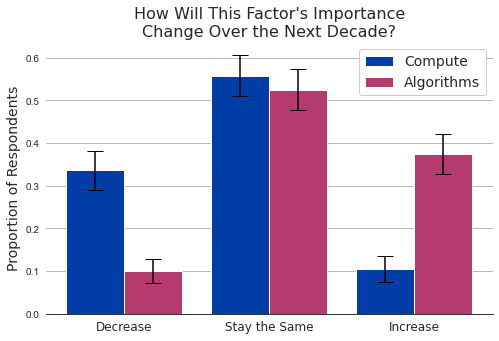

In [95]:
def figure6(df, output_folder, show = False):
    # Create an array to hold the values for the proportion of respondents saying that algorithms or compute will increase in importance, stay the same, or decrease
    data = pd.DataFrame({'Decrease': [0,0,0], 'Stay the Same': [0,0,0], 'Increase': [0,0,0], 'Total': [0,0,0]}, 
                       index = ['Compute', 'Algorithms', 'Total'])

    # Create a table based on how many respondents increased their assessment of a factor, decreased it, or did not change it
    for lab in (['Compute', 'Algorithms']):
        data['Decrease'][lab] += len(df[df[f'Past{lab}'] > df[f'Future{lab}']])
        data['Stay the Same'][lab] += len(df[df[f'Past{lab}'] == df[f'Future{lab}']])
        data['Increase'][lab] += len(df[df[f'Past{lab}'] < df[f'Future{lab}']])
    data['Total'] = np.sum(np.array(data)[:, :-1], axis=1)

    # Calculate the proportion falling into each of the three categories for each factor, and then calculate the confidence intervals
    props = np.array(data)[:-1, :-1] / np.expand_dims(np.array(data)[:-1, -1], axis=1)
    counts = np.expand_dims(np.array(data)[:-1, -1], axis=1)
    cis = t.ppf(1 - 0.05/2, df = counts - 1) * np.sqrt(props * (1 - props) / np.expand_dims(np.array(data)[:-1, -1], axis=1))

    # Print the resulting proportions and confidence intervals being plotted
    if show: 
        print('Proportions:')
        print(pd.DataFrame({'Decrease': props[:, 0], 'Stay the same': props[:, 1], 'Increase': props[:, 2]}, index=['Compute', 'Algorithms']))
        print('——————————\nConfidence Intervals:')
        print(pd.DataFrame({'Decrease': cis[:, 0], 'Stay the same': cis[:, 1], 'Increase': cis[:, 2]}, index=['Compute', 'Algorithms']))

    # Create the plot
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the bars for each proportion and add error bars
    ax.bar(np.arange(3) - 0.2, props[0, :], width=0.4, color=colors[0], label='Compute')
    ax.errorbar(np.arange(3) - 0.2, props[0, :], yerr=cis[0, :], color='black', fmt='none')
    ax.bar(np.arange(3) + 0.2, props[1, :], width=0.4, color=colors[1], label='Algorithms')
    ax.errorbar(np.arange(3) + 0.2, props[1, :], yerr=cis[1, :], color='black', fmt='none')

    # Adjust aesthetics and add the legend, then save the resulting figure
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(data.columns[:-1], fontsize=12, fontname='DejaVu Sans')
    ax.set_title('How Will This Factor\'s Importance\nChange Over the Next Decade?', fontsize=16, fontname='DejaVu Sans')
    ax.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont)
    plt.savefig(f'../results/{output_folder}/Fig6.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure6(no_snowball, 'figures', show = True)
figure6(all_responses, 'supplemental/with_snowball')
figure6(completed, 'supplemental/no_partial_responses')

## Compute Divides Exist but Do Not Worry Those Most Affected

<br/>
<br/>

### Finding 2.1. We find weak but conflicting evidence that a compute divide exists between AI researchers in private industry and those in academia. 

"When asked how expensive the total compute required by this project was, academics report spending significantly less than industry researchers (p < 0.001, Figure 7(a)). [...] When asked about the compute cost of this same project in terms of GPU-hours, however, the difference largely disappears (Figure 7(b)). [FN: In fact, the difference between the two distributions in Figure 7(b) no longer meets the threshold for statistical significance, though it is very close (p = 0.100).]"

In [97]:
# First, do a simple significance test on both the CompGPUs and CompCost fields using a Mann-Whitney U test
print(mannwhitneyu(no_snowball[no_snowball.Sector == 'Academia'].CompCost.dropna(), no_snowball[no_snowball.Sector == 'Industry'].CompCost.dropna()))
print(mannwhitneyu(no_snowball[no_snowball.Sector == 'Academia'].CompGPUs.dropna(), no_snowball[no_snowball.Sector == 'Industry'].CompGPUs.dropna()))

MannwhitneyuResult(statistic=2265.0, pvalue=1.6463368961440006e-07)
MannwhitneyuResult(statistic=7724.5, pvalue=0.09990502538193885)


Reported Cost Proportions
                    Academia  Industry
$0                  0.131868  0.041667
$1-1,000            0.153846  0.125000
$1,001-10,000       0.357143  0.229167
$10,001-100,000     0.269231  0.375000
$100,001-1,000,000  0.076923  0.187500
>$1,000,000         0.010989  0.041667
——————————
Reported GPU Hour Proportions
                Academia  Industry
None            0.140909  0.086420
<50             0.154545  0.098765
51-500          0.231818  0.246914
501-5,000       0.304545  0.333333
5,001-50,000    0.113636  0.135802
50,001-500,000  0.050000  0.074074
>500,000        0.004545  0.024691


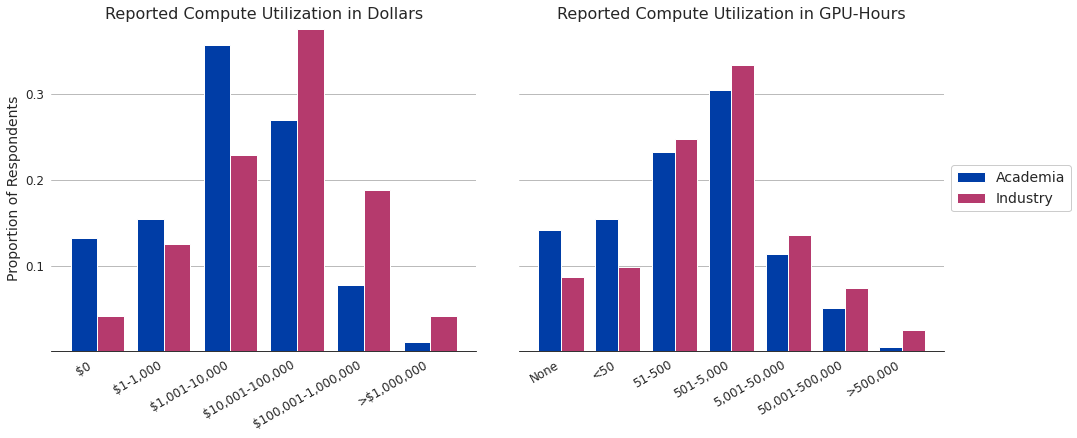

In [98]:
def figure7(df, output_folder, show = False):
    # Create a figure with two subplots, where the left hand side will show the differences in costs and the right hand side will show differences in GPU-hours used
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

    # Read in the `answer_key` file, which holds the labels corresponding to different answers
    answer_key = pd.read_csv('../data/answer_key.csv')
    left_labs = answer_key[answer_key['comp_total_cost'].notna()].comp_total_cost.tolist()
    right_labs = answer_key[answer_key['comp_training_cost'].notna()].comp_training_cost.tolist()

    # Plot the data for reported cost for both academia and industry
    ax0.bar(np.arange(len(left_labs)) - 0.2, df[df.Sector == 'Academia'].SigCost.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    #NOTE: There are zero responses from industry for the lowest cost threshold 
    ax0.bar(np.arange(len(left_labs)) + 0.2, df[df.Sector == 'Industry'].SigCost.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the results
    if show: 
        print('Reported Cost Proportions')
        print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].SigCost.value_counts(normalize=True).sort_index().tolist(),
                     'Industry': df[df.Sector == 'Industry'].SigCost.value_counts(normalize=True).sort_index().tolist()}, index = left_labs))

    # Adjust the aesthetics of the left-hand plot and add an annotation indicating the significance result
    ax0.set_xticks(np.arange(len(left_labs)))
    ax0.set_xticklabels(left_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax0.set_ylim([0,0.38])
    ax0.set_yticks([0.1,0.2,0.3])
    ax0.set_yticklabels(['0.1', '0.2', '0.3'], fontsize=12, fontname='DejaVu Sans')
    ax0.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax0.set_title('Reported Compute Utilization in Dollars', fontsize=16, fontname='DejaVu Sans')

    # Plot the data for reported GPU-hours for both academia and industry
    ax1.bar(np.arange(len(right_labs)) - 0.2, df[df.Sector == 'Academia'].SigGPUs.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    ax1.bar(np.arange(len(right_labs)) + 0.2, df[df.Sector == 'Industry'].SigGPUs.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the data 
    if show: 
        print('——————————\nReported GPU Hour Proportions')
        print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].SigGPUs.value_counts(normalize=True).sort_index().tolist(),
                 'Industry': df[df.Sector == 'Industry'].SigGPUs.value_counts(normalize=True).sort_index().tolist()}, index = right_labs))

    # Adjsut the aesthetics of the right-hand plot and add a legend to the right of the graph itself
    ax1.set_xticks(np.arange(len(right_labs)))
    ax1.set_xticklabels(right_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax1.set_title('Reported Compute Utilization in GPU-Hours', fontsize=16, fontname='DejaVu Sans')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=basefont)

    # Adjust space between the two grids and save the figure
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(f'../results/{output_folder}/Fig7.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure7(no_snowball, 'figures', show = True)
figure7(all_responses, 'supplemental/with_snowball')
figure7(completed, 'supplemental/no_partial_responses')

"[R]esponse rates for both questions were much lower for industry than for academics—78% of academics and only 64% of industry respondents reported an answer in terms of GPU hours, while 64% of academics and only 40% of industry respondents reported an answer in terms of cost."

AND 

"First, 320 respondents provided information about GPU hours, compared to only 257 respondents for cost."

In [110]:
# Print out total responses for the two questions
print('Responses for cost:', len(no_snowball[~no_snowball.CompCost.isna()]))
print('Responses for GPU-hours:', len(no_snowball[~no_snowball.CompGPUs.isna()]))

# Print out response rates by question and sector
for sector in ['Academia', 'Industry']:
    total = len(no_snowball[no_snowball.Sector == sector])
    for question in ['Cost', 'GPUs']:
        responses = len(no_snowball[(no_snowball.Sector == sector) & (~no_snowball[f'Comp{question}'].isna())])
        print(f'Response rate for {sector} and {question} is {round(100 * responses / total, 2)}%')

Responses for cost: 261
Responses for GPU-hours: 332
Response rate for Academia and Cost is 66.06%
Response rate for Academia and GPUs is 79.93%
Response rate for Industry and Cost is 39.17%
Response rate for Industry and GPUs is 65.0%


"82% of academics report using on-premise compute, with 46% reporting using exclusively on-premise compute. For industry, these figures are 52% and 22%, respectively. The differences in the proportions of both on-premise compute users and exclusive on-premise compute users were statistically significant by a chi-squared test of independence at p < 0.001."

In [127]:
# Create arrays to hold raw totals for on-premise users and exclusive on-premise users
onprem = []
exclusive = []
total = []

# Extract relevant counts and totals for both academia and industry
for sector in ['Academia', 'Industry']:
    total.append(len(no_snowball[(no_snowball.Sector == sector) & (~no_snowball.OnPremise.isna()) & (~no_snowball.CloudUser.isna())]))
    onprem.append(len(no_snowball[(no_snowball.Sector == sector) & (no_snowball.OnPremise == 1) & (~no_snowball.CloudUser.isna())]))
    exclusive.append(len(no_snowball[(no_snowball.Sector == sector) & (no_snowball.OnPremise == 1) & (no_snowball.CloudUser == 0)]))

# Format these values as a dataframe and print it out
onprem_users = pd.DataFrame({'On-Premise User': onprem, 'On-Premise ONLY': exclusive, 'Total': total, 'Percent On-Premise': 100 * np.array(onprem) / np.array(total), 
                            'Percent On-Premise ONLY': 100 * np.array(exclusive) / np.array(total)}, index = ['Academia', 'Industry'])
print(onprem_users)

# Also verify that these differences between industry and academia are statistically significant using a chi-squared test
print('p-value to reject independence of sector and on-premise use:', chi2_contingency([
    [onprem_users.loc['Academia', 'On-Premise User'], onprem_users.loc['Academia', 'Total'] - onprem_users.loc['Academia', 'On-Premise User']],
    [onprem_users.loc['Industry', 'On-Premise User'], onprem_users.loc['Industry', 'Total'] - onprem_users.loc['Industry', 'On-Premise User']]
])[1])
print('p-value to reject independence of sector and on-premise use:', chi2_contingency([
    [onprem_users.loc['Academia', 'On-Premise ONLY'], onprem_users.loc['Academia', 'Total'] - onprem_users.loc['Academia', 'On-Premise ONLY']],
    [onprem_users.loc['Industry', 'On-Premise ONLY'], onprem_users.loc['Industry', 'Total'] - onprem_users.loc['Industry', 'On-Premise ONLY']]
])[1])

          On-Premise User  On-Premise ONLY  Total  Percent On-Premise  \
Academia              224              126    273           82.051282   
Industry               61               26    118           51.694915   

          Percent On-Premise ONLY  
Academia                46.153846  
Industry                22.033898  
p-value to reject independence of sector and on-premise use: 1.2432803546482147e-09
p-value to reject independence of sector and on-premise use: 1.1964314930777031e-05


"In industry, the distribution of reported changes in compute needs almost perfectly tracks the distribution of reported changes in access, implying that although there has been significant growth in compute needs overall, researchers feel that their level of compute access has generally kept pace. The story is different in academia, where many more respondents reported needing more compute than reported actually being able to access more compute."

In [128]:
# First, do a simple significance test on both the NeedChanges and AccessChanges fields using a Mann-Whitney U test
# Here we are comparing the distributions of reported changes in needs and access SEPARATELY for academia and industry, we are not comparing academia to industry
print(mannwhitneyu(df[df.Sector == 'Academia'].NeedChanges.dropna(), df[df.Sector == 'Academia'].AccessChanges.dropna()))
print(mannwhitneyu(df[df.Sector == 'Industry'].NeedChanges.dropna(), df[df.Sector == 'Industry'].AccessChanges.dropna()))

MannwhitneyuResult(statistic=35671.0, pvalue=3.3418616454692964e-09)
MannwhitneyuResult(statistic=7091.5, pvalue=0.3265943250892951)


Changes in Needs and Access Level for ACADEMIA
                   Needs    Access
Much less       0.003650  0.014599
Somewhat less   0.021898  0.025547
About the same  0.233577  0.383212
Somewhat more   0.419708  0.441606
Much more       0.321168  0.135036
——————————
Changes in Needs and Access Level for INDUSTRY
                   Needs    Access
Much less       0.008333  0.016667
Somewhat less   0.033333  0.008333
About the same  0.166667  0.208333
Somewhat more   0.425000  0.425000
Much more       0.366667  0.341667


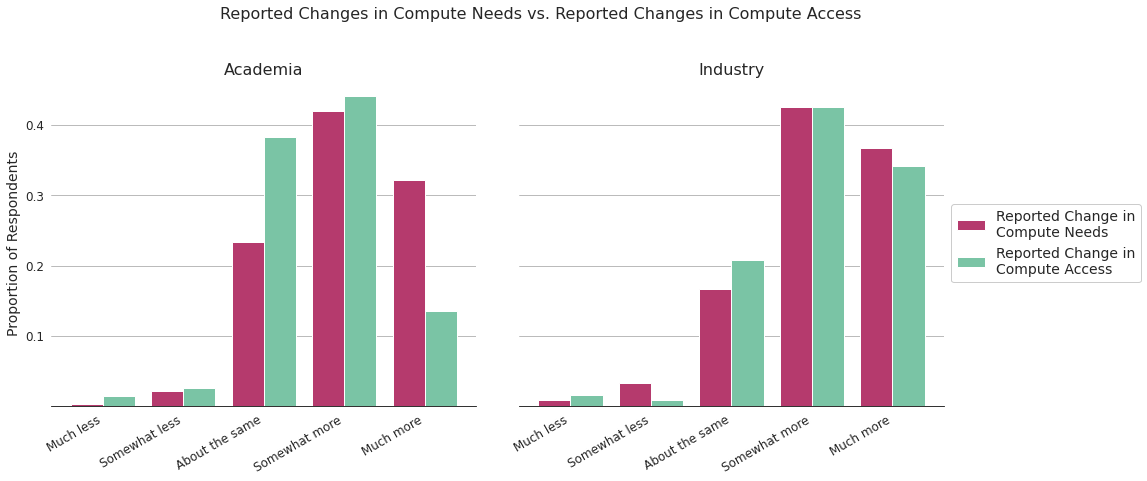

In [129]:
def figure8(df, output_folder, show = False):
    # Create the figure
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

    # Set the labels for different levels in the responses
    labs = ['Much less', 'Somewhat less', 'About the same', 'Somewhat more', 'Much more']

    # On the left-hand plot, plot the reported changes in compute NEEDS for academia in red and the reported changes in compute ACCESS in green
    ax0.bar(np.arange(len(labs)) - 0.2, df[df.Sector == 'Academia'].NeedChanges.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Reported Change in\nCompute Needs')
    ax0.bar(np.arange(len(labs)) + 0.2, df[df.Sector == 'Academia'].AccessChanges.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[2], label='Reported Change in\nCompute Access')

    # Print out the results
    if show: 
        print('Changes in Needs and Access Level for ACADEMIA')
        print(pd.DataFrame({'Needs': df[df.Sector == 'Academia'].NeedChanges.value_counts(normalize=True).sort_index().tolist(),
                 'Access': df[df.Sector == 'Academia'].AccessChanges.value_counts(normalize=True).sort_index().tolist()}, index = labs))

    # On the right-hand plot, plot the reported changes in compute NEEDS for industry in red and the reported changes in compute ACCESS in green
    ax1.bar(np.arange(len(labs)) - 0.2, df[df.Sector == 'Industry'].NeedChanges.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Reported Change in\nCompute Needs')
    ax1.bar(np.arange(len(labs)) + 0.2, df[df.Sector == 'Industry'].AccessChanges.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[2], label='Reported Change in\nCompute Access')

    # Print out the results
    if show: 
        print('——————————\nChanges in Needs and Access Level for INDUSTRY')
        print(pd.DataFrame({'Needs': df[df.Sector == 'Industry'].NeedChanges.value_counts(normalize=True).sort_index().tolist(),
                 'Access': df[df.Sector == 'Industry'].AccessChanges.value_counts(normalize=True).sort_index().tolist()}, index = labs))

    # Stylize the axes 
    for ax in [ax0, ax1]:
        ax.set_xticks(np.arange(len(labs)))
        ax.set_xticklabels(labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
        ax.set_yticks([0.1,0.2,0.3,0.4])
        ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4'], fontsize=12, fontname='DejaVu Sans')
    ax0.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')

    # Add titles to each subplot, a significance result to the left-hand plot, and a legend to the right of the right-hand plot, then adjust spacing and add a title
    ax0.set_title('Academia', fontsize=16, fontname='DejaVu Sans')
    ax1.set_title('Industry', fontsize=16, fontname='DejaVu Sans')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=basefont)
    fig.subplots_adjust(wspace=0.1)
    fig.suptitle('Reported Changes in Compute Needs vs. Reported Changes in Compute Access', fontsize=16, fontname='DejaVu Sans', y=1.05, x=0.55)

    plt.savefig(f'../results/{output_folder}/Fig8.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure8(no_snowball, 'figures', show = True)
figure8(all_responses, 'supplemental/with_snowball')
figure8(completed, 'supplemental/no_partial_responses')

### Finding 2.2. Academics do not cite lack of compute as a primary reason to leave academia. 

"When asked if they had ever seriously considered leaving academia to work in private industry, 65% of academics answered yes..."

In [133]:
# Print out the counts of people answering yes about leaving academia
no_snowball[no_snowball.Sector == 'Academia'].ConsideredLeaving.value_counts(dropna = False, normalize = True)

1.0    0.645985
0.0    0.354015
Name: ConsideredLeaving, dtype: float64

                     Proportions  Confidence Intervals
LeavingSalary           0.700565              0.067941
LeavingContribution     0.463277              0.073970
LeavingProjects         0.361582              0.071271
LeavingCompute          0.355932              0.071024
LeavingData             0.276836              0.066372


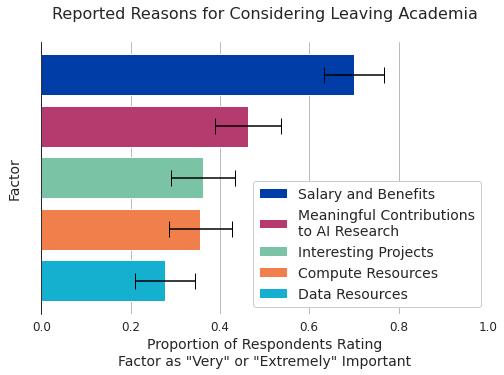

In [134]:
def figure9(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize=(8,5))

    # Create an array to hold the proportions of academics for each factor rating that factor as "very" or "extremely" important 
    factors = ['LeavingSalary', 'LeavingData', 'LeavingCompute', 'LeavingProjects', 'LeavingContribution']
    props = np.zeros(5,)
    n = np.zeros(5,)
    for i, lab in enumerate(factors):
        n[i] = len(df.dropna(subset = [lab]))
        props[i] = len(df[df[lab] >= 3.]) / n[i]

    # Calculate confidence intervals using the same method as previously
    cis = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt(props * (1-props) / n)

    # Print out the data
    if show: print(pd.DataFrame({'Proportions': props[np.argsort(props)[::-1]], 
                       'Confidence Intervals': cis[np.argsort(props)[::-1]]}, 
                       index = np.array(factors)[np.argsort(props)[::-1]]))

    # Plot the data for each factor in a different color and label it
    labels = ['Salary and Benefits', 'Data Resources', 'Compute Resources', 'Interesting Projects', 'Meaningful Contributions\nto AI Research']
    for i, (p, ci, lab) in enumerate(zip(props[np.argsort(props)[::-1]], cis[np.argsort(props)[::-1]], np.array(labels)[np.argsort(props)[::-1]])):
        ax.barh(5-i, p, color=colors[i], label=lab)
        ax.errorbar(p, 5-i, xerr=ci, color='black', fmt='none')

    # Adjust aesthetics, add title and legend
    ax.set_xlabel('Proportion of Respondents Rating\nFactor as \"Very\" or \"Extremely\" Important', fontsize=14, fontname='DejaVu Sans')
    ax.set_xlim([0,1])
    ax.set_xticks([0.,0.2,0.4,0.6,0.8,1.])
    ax.set_xticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=12, fontname='DejaVu Sans')
    ax.set_yticks([])
    ax.set_ylabel('Factor\n', fontsize=14, fontname='DejaVu Sans')
    ax.set_title('Reported Reasons for Considering Leaving Academia\n', fontsize=16, fontname='DejaVu Sans')
    ax.grid(axis='x')
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.legend(prop=basefont, loc=4)

    # Save the figure
    fig.savefig(f'../results/{output_folder}/Fig9.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure9(no_snowball, 'figures', show = True)
figure9(all_responses, 'supplemental/with_snowball')
figure9(completed, 'supplemental/no_partial_responses')

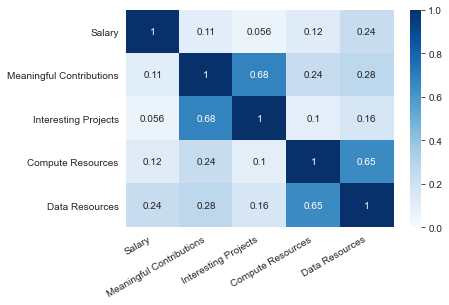

In [149]:
heatmap = np.array(no_snowball[['LeavingSalary', 'LeavingContribution', 'LeavingProjects', 'LeavingCompute', 'LeavingData']].corr(method = 'spearman'))

ax = sns.heatmap(heatmap, cmap = 'Blues', vmin = 0., annot = True)
ax.set_xticks(np.arange(5) + 0.5)
ax.set_xticklabels(['Salary', 'Meaningful Contributions', 'Interesting Projects', 'Compute Resources', 'Data Resources'], rotation = 30, ha = 'right')
ax.set_yticks(np.arange(5) + 0.5)
ax.set_yticklabels(['Salary', 'Meaningful Contributions', 'Interesting Projects', 'Compute Resources', 'Data Resources'], rotation = 0)

plt.savefig('../results/figures/leaving_correlations.jpg', dpi = 300, bbox_inches = 'tight')

"Academics appear slightly more likely to report being “moderately” or “extremely” concerned that they will not have enough compute to make meaningful research contributions in the next decade, but what differences do exist between the distributions are not significant."

In [152]:
# First use a Mann-Whitney U test to evaluate whether the two distributions are statistically different
mannwhitneyu(no_snowball[no_snowball.Sector == 'Academia'].ContributionConcern.dropna(), no_snowball[no_snowball.Sector == 'Industry'].ContributionConcern.dropna())

MannwhitneyuResult(statistic=14871.5, pvalue=0.06162675491590066)

                      Academia  Industry
Not at all concerned  0.189781  0.266667
Slightly concerned    0.189781  0.208333
Somewhat concerned    0.208029  0.158333
Moderately concerned  0.262774  0.233333
Extremely concerned   0.149635  0.133333


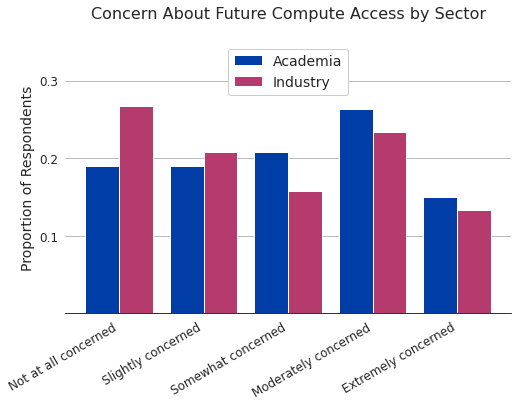

In [151]:
def figure10(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Assign labels for each response
    labels = ['Not at all concerned', 'Slightly concerned', 'Somewhat concerned', 'Moderately concerned', 'Extremely concerned']

    # Plot the data
    ax.bar(np.arange(len(labels)) - 0.2, df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    ax.bar(np.arange(len(labels)) + 0.2, df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the data
    if show: print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(),
                       'Industry': df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist()},
                       index = labels))

    # Adjust figure aesthetics, add title and axis labels, and add a legend
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax.set_ylim([0,0.35])
    ax.set_yticks([0.1,0.2,0.3])
    ax.set_yticklabels(['0.1', '0.2', '0.3'], fontsize=12, fontname='DejaVu Sans')
    ax.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.set_title('Concern About Future Compute Access by Sector\n', fontsize=16, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc=9)

    # Save the figure
    plt.savefig(f'../results/{output_folder}/Fig10.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure10(no_snowball, 'figures', show = True)
figure10(all_responses, 'supplemental/with_snowball')
figure10(completed, 'supplemental/no_partial_responses')

### Finding 2.3. Having greater access to compute correlates positively with being more concerned about compute. 

Proportions by GPU-Hours Used in Most Compute-Intensive Project
               Compute      Data    Talent
<50           0.106061  0.212121  0.590909
51–500        0.181818  0.298701  0.454545
501–5,000     0.290323  0.161290  0.473118
5,001–50,000  0.245283  0.150943  0.566038
>50,000       0.294118  0.205882  0.470588
——————————
Margins of Error by GPU-Hours Used in Most Compute-Intensive Project
               Compute      Data    Talent
<50           0.075695  0.100498  0.120867
51–500        0.087542  0.103883  0.113016
501–5,000     0.093482  0.075747  0.102825
5,001–50,000  0.118593  0.098675  0.136610
>50,000       0.158982  0.141083  0.174156


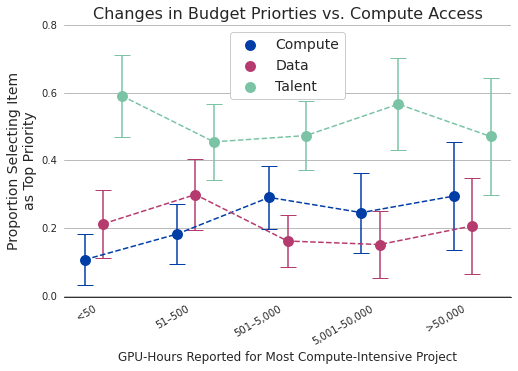

In [153]:
def figure11(df, output_folder, show = False): 
    # Create arrays that will hold, for each level of compute usage, the number of respondents and the proportion selecting data/talent/compute as a top priority,
    n = np.zeros((3,5))
    counts = np.zeros((3,5))

    # Fill in the arrays, while binning the bottom two and the top two GPU categories (due to low sample size)
    buckets = [[0,1], [2], [3], [4], [5,6]]
    n = np.array([len(df[(~df.PrioritySimplified.isna()) & (df.CompGPUs.isin(j))]) for j in buckets])
    for i, priority in enumerate(['Compute', 'Data', 'Talent']):
        counts[i] = [len(df[(df.PrioritySimplified == priority) & (df.CompGPUs.isin(j))]) for j in buckets]
    props = counts / n

    # Calculate the confidence intervvals / margins of error
    moes = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt( props * (1-props) / n )

    # Print out the calculated data
    labels = ['<50', '51–500', '501–5,000', '5,001–50,000', '>50,000']
    if show:
        print('Proportions by GPU-Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Compute': props[0], 'Data': props[1], 'Talent': props[2]}, index=labels))
        print('——————————\nMargins of Error by GPU-Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Compute': moes[0], 'Data': moes[1], 'Talent': moes[2]}, index=labels))

    # Create the plot
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the results
    for i, (p, moe, lab) in enumerate(zip(props, moes, ['Compute', 'Data', 'Talent'])):
        ax.errorbar(np.arange(len(labels)) - 0.15 + 0.2 * i, p, yerr=moe, ecolor=colors[i], fmt='--', color=colors[i])
        ax.scatter(np.arange(len(labels)) - 0.15 + 0.2 * i, p, s=80, facecolors=colors[i], edgecolors=colors[i], linewidths=2, label=lab)

    # Adjust aesthetics, add title, add legend, and save figure 
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=10, rotation=30, ha='right', fontname='DejaVu Sans')
    ax.set_xlabel('GPU-Hours Reported for Most Compute-Intensive Project', fontsize=12, fontname='DejaVu Sans')
    ax.set_yticks(np.arange(0.,1.,0.2))
    ax.set_yticklabels([str(round(i, 1)) for i in np.arange(0.,1.,0.2)], fontsize=10, fontname='DejaVu Sans')
    ax.set_ylabel('Proportion Selecting Item\nas Top Priority', fontsize=14, fontname='DejaVu Sans')
    ax.set_title('Changes in Budget Priorties vs. Compute Access', fontsize=16, fontname='DejaVu Sans')
    ax.legend(prop=basefont)
    plt.savefig(f'../results/{output_folder}/Fig11.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
    
# Plot the results, display results for the non-snowball responses
figure11(no_snowball, 'figures', show = True)
figure11(all_responses, 'supplemental/with_snowball')
figure11(completed, 'supplemental/no_partial_responses')

"For academics, the Spearman’s rho correlation between reported GPU utilization and concern over future contributions is 0.28, with p < 0.001. But for researchers in industry, while a slight positive correlation of 0.16 still exists, it is no longer significant (p = 0.153)."

In [156]:
# How is increased reported GPU-usage correlated with level of concern among academics?
x = no_snowball[(~no_snowball.CompGPUs.isna()) & (~no_snowball.ContributionConcern.isna()) & (no_snowball.Sector == 'Academia')].CompGPUs
y = no_snowball[(~no_snowball.CompGPUs.isna()) & (~no_snowball.ContributionConcern.isna()) & (no_snowball.Sector == 'Academia')].ContributionConcern
print(spearmanr(x, y))

# And what about among industry researchers?
x = no_snowball[(~no_snowball.CompGPUs.isna()) & (~no_snowball.ContributionConcern.isna()) & (no_snowball.Sector == 'Industry')].CompGPUs
y = no_snowball[(~no_snowball.CompGPUs.isna()) & (~no_snowball.ContributionConcern.isna()) & (no_snowball.Sector == 'Industry')].ContributionConcern
print(spearmanr(x, y))

SpearmanrResult(correlation=0.2774916299033652, pvalue=3.112290973671402e-05)
SpearmanrResult(correlation=0.16340849003460312, pvalue=0.15285689818691553)


Means by GPU-Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           1.387755  1.000000
51–500        2.104167  1.523810
501–5,000     2.072464  2.777778
5,001–50,000  2.361111  1.769231
>50,000       2.823529  1.538462
——————————
Confidence Intervals by GPU-Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           0.365289  0.740106
51–500        0.360586  0.653629
501–5,000     0.343010  0.498911
5,001–50,000  0.413626  0.991541
>50,000       0.581564  0.840794


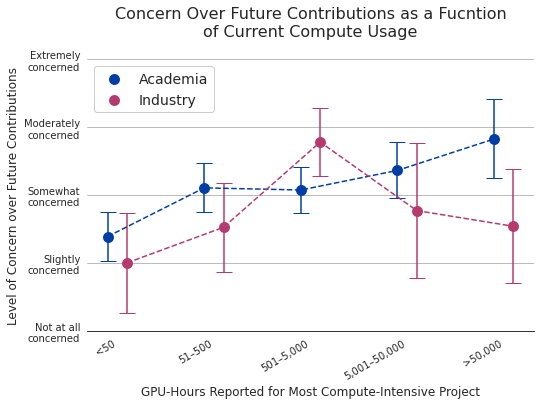

In [155]:
def figure12(df, output_folder, show = False):
    # Create arrays that will hold, for both academia and for industry, and for each level of compute usage, the number of respondents, the mean level of contribution concern,
    # and the standard deviation in the reported levels of contribution concern
    n = np.zeros((2,5))
    means = np.zeros((2,5))
    stds = np.zeros((2,5))

    # Fill in the arrays, while binning the bottom two and the top two GPU categories (due to low sample size)
    buckets = [[0,1], [2], [3], [4], [5,6]]
    for i, sector in enumerate(['Academia', 'Industry']):
        n[i] = [len(df[(df.Sector == sector) & (df.CompGPUs.isin(j)) & (~df.ContributionConcern.isna())]) for j in buckets]
        means[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.mean() for j in buckets]
        stds[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.std() for j in buckets]

    # Calculate margins of error using the equation 1.96 * std / sqrt(n)
    errors = t.ppf(1 - 0.05/2, df = n - 1) * stds / np.sqrt(n)

    # Print out the calculated data
    labels = ['<50', '51–500', '501–5,000', '5,001–50,000', '>50,000']
    if show: 
        print('Means by GPU-Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Academia': means[0], 'Industry': means[1]}, index=labels))
        print('——————————\nConfidence Intervals by GPU-Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Academia': errors[0], 'Industry': errors[1]}, index=labels))

    # Create the plot
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the results
    for i, (mean, err, lab) in enumerate(zip(means, errors, ['Academia', 'Industry'])):
        ax.errorbar(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, yerr=err, ecolor=colors[i], fmt='--', color=colors[i])
        ax.scatter(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, s=80, facecolors=colors[i], edgecolors=colors[i], linewidths=2, label=lab)

    # Adjust figure aesthetics, add axis captions and title, add legend, and save the figure
    y_labels = ['Not at all\nconcerned', 'Slightly\nconcerned', 'Somewhat\nconcerned', 'Moderately\nconcerned', 'Extremely\nconcerned']
    ax.set_ylim([0.,4.])
    ax.set_yticks(range(5))
    ax.set_yticklabels(y_labels, fontsize=10, rotation=0, ha='right', fontname='DejaVu Sans')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=10, rotation=30, ha='right', fontname='DejaVu Sans')
    ax.set_ylabel('Level of Concern over Future Contributions', fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('GPU-Hours Reported for Most Compute-Intensive Project', fontsize=12, fontname='DejaVu Sans')
    ax.set_title('Concern Over Future Contributions as a Fucntion\nof Current Compute Usage\n', fontsize=16, fontname='DejaVu Sans')
    ax.legend(prop=basefont)
    plt.savefig(f'../results/{output_folder}/Fig12.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure12(no_snowball, 'figures', show = True)
figure12(all_responses, 'supplemental/with_snowball')
figure12(completed, 'supplemental/no_partial_responses')

"Similar results emerge when looking at almost any question in our survey designed to measure how important a researcher views compute. Among academics, reporting higher quantities of compute in a researcher’s most compute-intensive project is positively correlated with more frequently abandoning (ρ  = 0.19; p = 0.005), revising (ρ = 0.31; p < 0.001), or rejecting (ρ = 0.31; p < 0.001) projects due to a lack of compute; with reporting a lack of compute as a more important factor in considering leaving academia (ρ = 0.33, p < 0.001); with viewing compute as a more significant factor contributing to the lack decade of AI progress (ρ = 0.18; p = 0.008); and with predicting compute as a more significant factor for AI progress over the next decade (ρ = 0.12; p = 0.068)."

In [159]:
# Additional Spearman's rho calculations 
# Frequency of ABANDONING projects vs. compute usage (for academics) 
x = df[(~df.CompGPUs.isna()) & (~df.ComputeAbandon.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.ComputeAbandon.isna()) & (df.Sector == 'Academia')].ComputeAbandon
print('Project Abandonment\n', spearmanr(x, y))

# Frequency of REVISING projects vs. compute usage (for academics) 
x = df[(~df.CompGPUs.isna()) & (~df.ComputeRevise.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.ComputeRevise.isna()) & (df.Sector == 'Academia')].ComputeRevise
print('Project Revision\n', spearmanr(x, y))

# Frequency of REJECTING projects vs. compute usage (for academics) 
x = df[(~df.CompGPUs.isna()) & (~df.ComputeReject.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.ComputeReject.isna()) & (df.Sector == 'Academia')].ComputeReject
print('Project Rejection\n', spearmanr(x, y))

# Importance in considering leaving academia vs. compute usage (for academics)
x = df[(~df.CompGPUs.isna()) & (~df.LeavingCompute.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.LeavingCompute.isna()) & (df.Sector == 'Academia')].LeavingCompute
print('Leaving Academia\n', spearmanr(x, y))

# Importance of compute over the last decade vs. compute usage (for academics)
x = df[(~df.CompGPUs.isna()) & (~df.PastCompute.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.PastCompute.isna()) & (df.Sector == 'Academia')].PastCompute
print('Past Decade Importance\n', spearmanr(x, y))

# Importance of compute over the next decade vs. compute usage (for academics)
x = df[(~df.CompGPUs.isna()) & (~df.FutureCompute.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.FutureCompute.isna()) & (df.Sector == 'Academia')].FutureCompute
print('Next Decade Importance\n', spearmanr(x, y))

Project Abandonment
 SpearmanrResult(correlation=0.1881157352848051, pvalue=0.005223699602194465)
Project Revision
 SpearmanrResult(correlation=0.31153595841634135, pvalue=2.5831378603864355e-06)
Project Rejection
 SpearmanrResult(correlation=0.3051545292917341, pvalue=4.220266090556578e-06)
Leaving Academia
 SpearmanrResult(correlation=0.33437478116277186, pvalue=3.947857662883782e-05)
Past Decade Importance
 SpearmanrResult(correlation=0.17826919093759774, pvalue=0.008186965841665875)
Next Decade Importance
 SpearmanrResult(correlation=0.12369630520808363, pvalue=0.06832445032904443)


# Researchers Have a Variety of Opinions About the NAIRR

            WantsData  WantsCompute  WantsStaff  WantsGrants  WantsStandards
Academia          149           183         107          248              73
Industry           79            78          31           69              43
Government         10             6           9            7               8


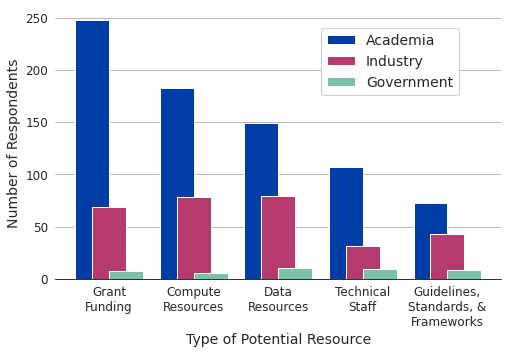

In [160]:
def figure13(df, output_folder, show = False):
    # Create an array to hold the data
    data = pd.DataFrame({'WantsData': [0, 0, 0], 'WantsCompute': [0, 0, 0], 
                         'WantsStaff': [0, 0, 0], 'WantsGrants': [0, 0, 0], 
                         'WantsStandards': [0, 0, 0]}, 
                        index=['Academia', 'Industry', 'Government'])

    # Fill in and print out the dataframe
    for col in data.columns:
        for sector in data.index:
            data.loc[sector, col] = df[df.Sector == sector][col].sum()
    if show: print(data)

    # Calculate totals and sort the data
    totals = np.sum(np.array(data), axis=0)
    sorted_data = np.array(data)[:, np.argsort(totals)[::-1]]

    # Initialize labels for plotting and create figure
    fig, ax = plt.subplots(figsize=(8,5))

    # Add another layer to each of the five columns for all academics, then all industry researchers, then all government researchers and update the starting position for the next iteration
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        ax.bar(np.arange(5) - 0.2 + 0.2 * i, sorted_data[i], color=colors[i], label = s, width = 0.4)

    # Adjust figure aesthetics and labels
    labels = ['Grant\nFunding', 'Compute\nResources', 'Data\nResources', 'Technical\nStaff', 'Guidelines,\nStandards, &\nFrameworks']
    ax.set_ylabel('Number of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.set_yticks(np.arange(0, 300, 50))
    ax.set_yticklabels([str(i) for i in np.arange(0, 300, 50)], fontsize=12, fontname='DejaVu Sans')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels, fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('Type of Potential Resource', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc='center', bbox_to_anchor = (0.75, 0.8))

    # Save and display the image
    plt.savefig(f'../results/{output_folder}/Fig13.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure13(no_snowball, 'figures', show = True)
figure13(all_responses, 'supplemental/with_snowball')
figure13(completed, 'supplemental/no_partial_responses')